# Reinforcement Learning - Lab Solution

## Introduction
In this lab you will take what you have learned about Reinforcement Learning and build an AI capable of playing a game. That game is called CartPole and involves balancing a pole that is on a cart.
<br>
<br>
More info about the environment can be found here
<br>
http://gym.openai.com/envs/CartPole-v1/
<br>
<br>
This is a great first environment to try out RL on because it is siginificantly less expensive to train than other environments.

## Objectives
You will be able to:
* Build a DQN agent
* Train the agent to play CartPole, achieving an average score of at least 500

## Importing libraries
Let's start by importing the necessary libraries.

In [6]:
import random
import numpy as np
import keras
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense
from collections import deque
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import gym
import pickle
import time

Using TensorFlow backend.


## Setting up environment
Now we need to create the environment. The maximum number of steps in the game is by default set to 200. For this lab we will want to achieve an average score of 500, so we need to increase the max episode steps to 1000.

In [7]:
env = gym.make('CartPole-v1')
env._max_episode_steps = 1000

We can view the size of the action space by running the following command.

In [8]:
env.action_space

Discrete(2)

This tells us that there are 2 possible actions - 0 and 1. In this environment 0 correspondings to the cart moving left and 1 corresponds to the cart moving right.

Below shows the observation space for CartPole. This is the data we will get for each state of the game. These 4 variables will be what we use to train our model. It is important to note that these values will be normalized to [0,1] before they are given to us in the state data.

    Observation: 
        Type: Box(4)
        Num	Observation                 Min         Max
        0	Cart Position             -4.8            4.8
        1	Cart Velocity             -Inf            Inf
        2	Pole Angle                 -24 deg        24 deg
        3	Pole Velocity At Tip      -Inf            Inf

Some addtional info can be seen below regarding how the game decides it has lost.

    Termination: 
        Pole Angle is more than 12 degrees
        Cart Position is more than 2.4 (center of the cart reaches the edge of the display)

Scoring in this game is simple - each step that is made without ending the game will grant +1 point. A step that terminates the game will grant -1 point.

## Baseline performance

Now let's get the environment up and running and have it play a couple games randomly so we can get an idea of the baseline performance. We will keep track of the score each game so that we can get an average per 100 games. We will also plot the scores of each game to get idea of the variation in scores.

Game 0 score: 15
Game 1 score: 15
Game 2 score: 32
Game 3 score: 16
Game 4 score: 22
Game 5 score: 26
Game 6 score: 23
Game 7 score: 14
Game 8 score: 16
Game 9 score: 15
Game 10 score: 47
Game 11 score: 9
Game 12 score: 61
Game 13 score: 28
Game 14 score: 35
Game 15 score: 53
Game 16 score: 19
Game 17 score: 18
Game 18 score: 28
Game 19 score: 30
Game 20 score: 13
Game 21 score: 13
Game 22 score: 15
Game 23 score: 13
Game 24 score: 38
Game 25 score: 16
Game 26 score: 34
Game 27 score: 10
Game 28 score: 19
Game 29 score: 17
Game 30 score: 36
Game 31 score: 21
Game 32 score: 14
Game 33 score: 36
Game 34 score: 23
Game 35 score: 15
Game 36 score: 18
Game 37 score: 27
Game 38 score: 17
Game 39 score: 12
Game 40 score: 15
Game 41 score: 15
Game 42 score: 15
Game 43 score: 36
Game 44 score: 18
Game 45 score: 28
Game 46 score: 24
Game 47 score: 66
Game 48 score: 11
Game 49 score: 41
Game 50 score: 44
Game 51 score: 19
Game 52 score: 18
Game 53 score: 16
Game 54 score: 15
Game 55 score: 14
Gam

Text(0, 0.5, 'Score')

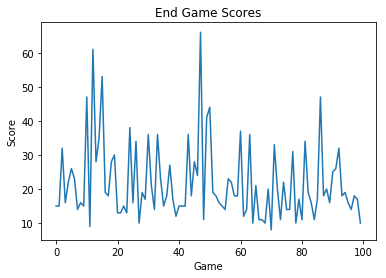

In [9]:
n_games = 100
n_steps = 1000
scores = []
for game in range(n_games):
    state = env.reset()
    for t in range(n_steps):
        env.render()
        action = env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        if done:
            print('Game ' + str(game) + ' score: ' + str(t))
            scores.append(t)
            break
env.close()
plt.plot(scores)
plt.title('End Game Scores')
plt.xlabel('Game')
plt.ylabel('Score')

Our average score per 100 games is then:

In [10]:
np.mean(scores)

21.71

## Building a DQN Agent
Now we can start building the agent that will learn to play CartPole.

We first want to choose and initialize our parameters.

For each state we are given 4 values, thus the input_shape for our network will be 4.

In [11]:
input_shape = 4

The batch_size will be 64. This means that every time we perform experience replay, we will sample 64 different memories and train the model on those.

In [12]:
batch_size = 64

We will set the total number of games to 2000. Almost certainly the model will reach its goal performance after less games (~500-1000) but just in case it takes longer we will extend the maximum number of games.
<br>
<br>
The number of steps will be set to 1000 which is the maxmimum number of steps we set initially.
<br>
<br>
We can also declare our score goal of 500 (avg per 100 games).

In [13]:
n_games = 2000
n_steps = 1000
score_goal = 500

For our epsilon greedy policy, we will start epsilon off at 1 and decay it by 0.95 after each training session. This way, over time, the network will rely more and more on its own predictions for moves.

In [14]:
epsilon = 1
epsilon_decay = 0.995

Gamma is our reward discount. This lessens the value of future rewards when calculating Q-values. The value is 0.95 is the most common value used.

In [15]:
gamma = 0.95

Lastly, we want to initialize our memory. We will use an object known as a deque. A deque is a lot like a normal list, except that it has a max length and once that max length is reached, a new item added to the deque will cause the oldest item in the deque to be deleted. That way we only keep a maximum number of memories in storage at one time.

In [16]:
memory = deque(maxlen=10000)

## Neural Network
Now let's build and intial both our primary model and target model.

This architecture was found mostly through trial and error. Feel free to modify it. Odds are there is a better architecture that will train the model faster.
<br>
<br>
Note that our input_dim is equal to our input_shape - 4. Also, the final layer of the network has 2 neurons - corresponding to our two possible actions: left or right. It is essential to use a linear activation function at the final layer.

In [17]:
model = Sequential()
model.add(Dense(16, input_dim=input_shape, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(2, activation='linear'))
model.compile(loss="mse", optimizer=Adam(lr=0.001))
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                80        
_________________________________________________________________
dense_2 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 18        
Total params: 1,306
Trainable params: 1,306
Non-trainable params: 0
_________________________________________________________________
None


Now we can use the same architecture to create our target model.

In [18]:
target_model = Sequential()
target_model.add(Dense(16, input_dim=input_shape, activation='relu'))
target_model.add(Dense(32, activation='relu'))
target_model.add(Dense(16, activation='relu'))
target_model.add(Dense(8, activation='relu'))
target_model.add(Dense(2, activation='linear'))
target_model.compile(loss="mse", optimizer=Adam(lr=0.001))

## Agent Methods
In order to train our models, we need to set up the functions required for a DQN.

The first two methods will help our agent choose an action. <br><br>
<b>choose_action</b> will generate a random number, if it is less than our current epsilon value, then a random move will be chosen. If the random number is greater than our current epsilon value, we will need to predict a value.

In [19]:
def choose_action(state):
    if np.random.rand() <= epsilon:    
        action = random.choice([0,1])
    else:
        action = predict_action(state)
    return action

<b>predict_action</b> will take in a state and predict the Q-values for that state for each action. Then we can use argmax() to get the action with the highest Q-value and return that action.
<br>
<br>
Note that we are using the target model to predict here.

In [20]:
def predict_action(state):
    q_values = target_model.predict(state)
    action = np.argmax(q_values[0])
    return action

Next we want to create a function that will store the agent's experiences into memory. The function is fairly straightforward, we will simply pass in the current state, the performed action, the reward, the next state, and the 'done' flag and append those values as a tuple into our memory deque.

In [21]:
def remember(state, action, reward, next_state, done):
    memory.append((state, action, reward, next_state, done))

We need two additional helper functions - one to decay our epsilon value and one to transfer the weights of the primary model to the target model. These are both fairly straight forward.

In [22]:
def decrease_epsilon():
    global epsilon
    epsilon *= epsilon_decay
    
def transfer_weights():
    target_model.set_weights(model.get_weights()) 

Now for probably the most complicated of the methods - experience replay.

The way this method works is, first we check and make sure we have enough experience in memory to create a batch of our selected batch_size.
<br>
<br>
Next we create our batches by randomly sampling our memory a number of times equal to batch_size.
<br>
<br>
Then we iterate through each batch. For each batch, we calculate the updated Q-value. The updated Q-value is calculated by using the Q-value formula. <br><br>
     <img src ='q_formula.png'></img>

Using this formula, the Q-value is calculated by adding together the current reward and the maximum possible Q-value of the next state, discount by our gamma value.
<br><br>
Note that we are using the target model to make this prediction.
<br><br>
Next we want to grab the current predicted Q-values for the given state.
<br>
<br>
We then update only the Q-value for the chosen action, leaving the other Q-value the same.
<br>
<br>
Our primary model is then fitted on the state and the Q-values.
<br>
<br>
Lastly, after each training session, we want to decay our epsilon value and also transfer the weights from the primary model to the target model.

In [23]:
def experience_replay():
    if len(memory) < batch_size:
        return
    print('**training**')
    batch = random.sample(memory, batch_size)
    for state, action, reward, next_state, done in batch:
        q_update = reward
        if not done:
            q_update = (reward + gamma * np.amax(target_model.predict(next_state)[0]))
        q_values = target_model.predict(state)
        q_values[0][action] = q_update
        model.fit(state, q_values, verbose=0)
    decrease_epsilon() 
    transfer_weights()

In order to speed up training, we can adjust one of our input values - cart position - to force it into bins. This will help to shrink our overall state size. This works because the agent will still be learning the position of the cart on the rail, it will just be given more of a general position instead of a very specific position.
<br>
<br>
You don't have to worry too much about how exactly this code works, just know that each state needs to pass through the <b>cart_position_to_bin</b> function to adjust the cart position values.
<br>
<br>
Specifically we will be create 5 bins of cart positions. Feel free to experiment with more or less.

In [32]:
n_bins = 5
bin_size = 1/n_bins
bins = []
for i in range(n_bins):
    bins.append((0, bin_size*i, i))

def cart_position_to_bin(state):
    position = state[0]
    for b in bins:
        if position>=b[0] and position<=b[1]:
            binned_position = b[2]
            state[0] = binned_position
            break
    return state

In order to get our state to be the correct size for the neural network, we also need to reshape the array. Below is a method to do this, coupled with the above cart position function to give you one state preprocessing method. Make sure to pass each state and next_state through this function.

In [33]:
def preprocess_state(state):
    state = cart_position_to_bin(state)
    state = np.reshape(state, [1, input_shape])
    return state

All the prework is now complete. We have all the tools necessary to start training our agent!

## Training the agent
Alright! Now it's time to start training. To do this, we will need to build a loop that will play through games of CartPole, training our agent along the way.
<br><br>
Provided below is a basic skeleton of this loop. Use what you have learned from the lesson and this lab in order to complete it. If you get lost you can always check the solution.
<br><br>
(Warning: this process may take some time. It takes anywhere from 30-60 minutes on my machine but that may be more or less depending on your computer and GPU.)

In [34]:
start_time = time.time()
scores = []
avgs = []
for game in range(n_games):
    ## Each game, we need to reset the environment, grab the intial state and preprocess it
    state = env.reset()
    state = preprocess_state(state)

    for t in range(n_steps):
        ## After each move, we need to do the following:
        ## 1) render the environment
        ## 2) decide on an action for this turn
        ## 3) perform that action, grabbing the next state, reward, 'done' flag, and 'info' object
        ## 4) preprocess the next state
        ## 5) remember this experience
        ## 6) set state=next_state to prepare for the next round
        ## 7) check if game is done. if so, record the score,
        ##    calculate the rolling average score (average score per last 100 games),
        ##    store the rolling average
        ## 8) check if average score goal has been reached, if so break out of game loop
        ## 9) if we need to keep playing, perform experience replay
        env.render()
        action = choose_action(state)
        next_state, reward, done, info = env.step(action)
        next_state = preprocess_state(next_state)
        remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            scores.append(t)
            if len(scores)>=100:
                avg_100 = np.mean(scores[-100:])
            else:
                avg_100 = 0
            avgs.append(avg_100)
            print ("Game: " + str(game) + ", exploration: " + str(round(epsilon,2)) + ", score: " + str(t) + ' - avg score/100 games: ' + str(avg_100))
            break
    if avg_100 >= score_goal:
        print('Completed after ' + str(game) + ' games - Averaging over ' + str(score_goal) + 'points per 100 games')
        break
    experience_replay()
env.close()
print("--- %s seconds ---" % (time.time() - start_time))

Game: 0, exploration: 1, score: 17 - avg score/100 games: 0
Game: 1, exploration: 1, score: 16 - avg score/100 games: 0
Game: 2, exploration: 1, score: 15 - avg score/100 games: 0
Game: 3, exploration: 1, score: 9 - avg score/100 games: 0
Game: 4, exploration: 1, score: 13 - avg score/100 games: 0
**training**
Instructions for updating:
Use tf.cast instead.
Game: 5, exploration: 0.99, score: 16 - avg score/100 games: 0
**training**
Game: 6, exploration: 0.99, score: 20 - avg score/100 games: 0
**training**
Game: 7, exploration: 0.99, score: 26 - avg score/100 games: 0
**training**
Game: 8, exploration: 0.98, score: 12 - avg score/100 games: 0
**training**
Game: 9, exploration: 0.98, score: 24 - avg score/100 games: 0
**training**
Game: 10, exploration: 0.97, score: 13 - avg score/100 games: 0
**training**
Game: 11, exploration: 0.97, score: 22 - avg score/100 games: 0
**training**
Game: 12, exploration: 0.96, score: 20 - avg score/100 games: 0
**training**
Game: 13, exploration: 0.96, 

Game: 104, exploration: 0.61, score: 35 - avg score/100 games: 32.67
**training**
Game: 105, exploration: 0.6, score: 148 - avg score/100 games: 33.99
**training**
Game: 106, exploration: 0.6, score: 30 - avg score/100 games: 34.09
**training**
Game: 107, exploration: 0.6, score: 37 - avg score/100 games: 34.2
**training**
Game: 108, exploration: 0.59, score: 54 - avg score/100 games: 34.62
**training**
Game: 109, exploration: 0.59, score: 87 - avg score/100 games: 35.25
**training**
Game: 110, exploration: 0.59, score: 100 - avg score/100 games: 36.12
**training**
Game: 111, exploration: 0.58, score: 77 - avg score/100 games: 36.67
**training**
Game: 112, exploration: 0.58, score: 68 - avg score/100 games: 37.15
**training**
Game: 113, exploration: 0.58, score: 22 - avg score/100 games: 37.16
**training**
Game: 114, exploration: 0.58, score: 11 - avg score/100 games: 37.09
**training**
Game: 115, exploration: 0.57, score: 20 - avg score/100 games: 37.07
**training**
Game: 116, explora

Game: 204, exploration: 0.37, score: 126 - avg score/100 games: 133.12
**training**
Game: 205, exploration: 0.37, score: 250 - avg score/100 games: 134.14
**training**
Game: 206, exploration: 0.36, score: 140 - avg score/100 games: 135.24
**training**
Game: 207, exploration: 0.36, score: 154 - avg score/100 games: 136.41
**training**
Game: 208, exploration: 0.36, score: 115 - avg score/100 games: 137.02
**training**
Game: 209, exploration: 0.36, score: 214 - avg score/100 games: 138.29
**training**
Game: 210, exploration: 0.36, score: 190 - avg score/100 games: 139.19
**training**
Game: 211, exploration: 0.35, score: 217 - avg score/100 games: 140.59
**training**
Game: 212, exploration: 0.35, score: 90 - avg score/100 games: 140.81
**training**
Game: 213, exploration: 0.35, score: 218 - avg score/100 games: 142.77
**training**
Game: 214, exploration: 0.35, score: 194 - avg score/100 games: 144.6
**training**
Game: 215, exploration: 0.35, score: 33 - avg score/100 games: 144.73
**traini

Game: 302, exploration: 0.22, score: 154 - avg score/100 games: 404.27
**training**
Game: 303, exploration: 0.22, score: 37 - avg score/100 games: 401.65
**training**
Game: 304, exploration: 0.22, score: 54 - avg score/100 games: 400.93
**training**
Game: 305, exploration: 0.22, score: 43 - avg score/100 games: 398.86
**training**
Game: 306, exploration: 0.22, score: 116 - avg score/100 games: 398.62
**training**
Game: 307, exploration: 0.22, score: 84 - avg score/100 games: 397.92
**training**
Game: 308, exploration: 0.22, score: 107 - avg score/100 games: 397.84
**training**
Game: 309, exploration: 0.22, score: 49 - avg score/100 games: 396.19
**training**
Game: 310, exploration: 0.22, score: 26 - avg score/100 games: 394.55
**training**
Game: 311, exploration: 0.21, score: 667 - avg score/100 games: 399.05
**training**
Game: 312, exploration: 0.21, score: 205 - avg score/100 games: 400.2
**training**
Game: 313, exploration: 0.21, score: 982 - avg score/100 games: 407.84
**training**

Now that training is finished, let's plot the rolling average scores to see how the agent improved over time.

Text(0, 0.5, 'Score')

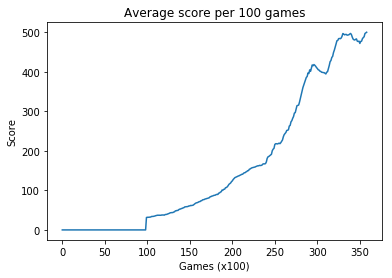

In [37]:
plt.plot(avgs)
plt.title('Average score per 100 games')
plt.xlabel('Games (x100)')
plt.ylabel('Score')

## Summary
Congratulations! You just trained your first RL model! After completing the rite of passage that is CartPole. <br><br>
You are now eligible to try out other environments. 
A word of caution though - the Atari games may be the most exciting and enticing environments to train in, but they may take several days of training before convergence. They also may involve image data and the use of Convolutional Neural Networks so make sure you are comfortable with those first.

Finally, we can do a quick comparison of baseline CartPole vs our trained CartPole agent.
<br><br>
These blocks will run both a random agent and our trained agent for 3 games. It also adds a small delay at each step so that you can watch both agents in action.

In [54]:
## Random Agent
n_games = 3
n_steps = 1000
scores = []
for game in range(n_games):
    state = env.reset()
    for t in range(n_steps):
        time.sleep(0.05)
        env.render()
        action = env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        if done:
            print('Game ' + str(game) + ' score: ' + str(t))
            scores.append(t)
            break
env.close()

Game 0 score: 19
Game 1 score: 39
Game 2 score: 14


In [55]:
## DQN Agent
n_games = 3
n_steps = 1000
scores = []
for game in range(n_games):
    state = env.reset()
    state = preprocess_state(state)
    for t in range(n_steps):
        time.sleep(0.05)
        env.render()
        action = choose_action(state)
        next_state, reward, done, info = env.step(action)
        next_state = preprocess_state(next_state)
        state = next_state
        if done:
            print('Game ' + str(game) + ' score: ' + str(t))
            scores.append(t)
            break
env.close()

Game 0 score: 733
